task 2.1: Make a DataModel class that reads the output of the DataAquisition class (from task1) in its __init__()  

task 2.2: Make a function in DataModel to make a linear regression. I suggest you try to do it on your own with only vanilla python and the class notes. If you are lost, you can find practical info here on how to use already made libraries: https://www.geeksforgeeks.org/machine-learning/regularization-in-machine-learning/Lenker til en ekstern side.  The issue here will be data structure: np.array vs list of list vs pandas DataFrames.  

task 2.3: Make a function that split the data you got from DataAquisition into train, validation and test. Do it  with vanilla python. You need to make sure you understand the data structure.  

task 2.4: Make a function that computes MSE (make your own, don't copy from my notes :P )  

task 2.5: Make a function to make NN. It would be essentially a wrapper of other libraries, I suggest to use Keras:  https://www.geeksforgeeks.org/machine-learning/how-to-create-models-in-keras/  . You should have acquired enough notions to handle this tool.  

task 2.6: Make a function that does K_MEAN and GMM (we will discuss them next week)  

Once these methods (recipes) are done, you can now make cakes! :) :  

task 2.7: Make a linear regression on all your data (statistic ).  

task 2.8: Make a linear regression on all your train data and test it on your validation.  

task 2.9: Compute the MSE on your validation data.   

task 2.10: Try for different distribution of initial data point, (a) Discuss how different functions can be used in the linear regression, and different NN architecture. (b) Discuss how you can use the validation data for the different cases. (c) Discuss the different outcome from the different models when using the full dataset to train and when you use a different ML approach. (d) Discuss the outcomes you get for K-means and GMM. (e) Discuss how you can integrate supervised and unsupervised methods for your case.  

In [18]:
import sys
sys.path.append('../MOD550-task1') # Adjust the path to find data_aquisition module
from data_aquisition import DataAquisition as aq


import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.linear_model import LinearRegression
from tensorflow import keras
from keras.layers import Input
from keras.layers import Dense
from keras import layers


class DataModel:
    def __init__(self):
        self.data = aq().data

    def scatter_plots_features_vs_rating(self):
        """
        Creates scatter plots for each feature (Runtime, Release year, Words in title, Length of title)
        against Rating.
        """
        
        # Convert column dict to list of row dicts
        columns = list(self.data.keys())
        n_rows = len(self.data[columns[0]])
        data_rows = [{col: self.data[col][i] for col in columns} for i in range(n_rows)]

        features = ['Runtime', 'Release year', 'Words in title', 'Length of title']
        ratings = [row['Rating'] for row in data_rows]

        plt.figure(figsize=(16, 4))
        for i, feat in enumerate(features):
            plt.subplot(1, 4, i + 1)
            x = [row[feat] for row in data_rows]
            y = ratings
            plt.hexbin(x, y, gridsize=40, cmap='viridis', mincnt=1) # Hexbin for better visualization with many points
            plt.xlabel(feat)
            plt.ylabel('Rating')
            plt.title(f'{feat} vs Rating')
            plt.colorbar(label='Counts')
        plt.tight_layout()
        plt.show()

    def linear_regression(self, x, y):
        """
        Performs simple linear regression using the least squares method.
        Args:
            x (list or array-like): The independent variable values.
            y (list or array-like): The dependent variable values.
        Returns:
            tuple: Intercept (b0) and slope (b1) of the regression line.
        """
        n = len(x)
        x_mean = sum(x) / n
        y_mean = sum(y) / n
        numerator = sum((x[i] - x_mean) * (y[i] - y_mean) for i in range(n))
        denominator = sum((x[i] - x_mean) ** 2 for i in range(n))
        b1 = numerator / denominator
        b0 = y_mean - b1 * x_mean
        return b0, b1

    def predict(self, x_new, b0, b1):
        """
        Predicts the dependent variable value for a new independent variable input using the linear regression coefficients.
        Args:
            x_new: The new value of the independent variable.
            b0: Intercept of the regression line.
            b1: Slope of the regression line.
        Returns:
            Predicted value of the dependent variable.
        """
        return b0 + b1 * x_new
    
    def predict_linear_regression(self, x_new, x=None, y=None):
        """
        Predicts the dependent variable value for a new independent variable input using linear regression.
        If x and y are not provided, uses the data loaded in self.data, namely 'Release year' as x and 'Rating' as y.
        Args:
            x_new: The new value of the independent variable to predict for.
            x: List or array-like of independent variable values.
            y: List or array-like of dependent variable values.
        Returns:
            Predicted value of the dependent variable for x_new.
        """
        if x is None and y is None:
            x = self.data['Release year']
            y = self.data['Rating']
        elif x is None or y is None:
            raise ValueError("Both x and y must be provided if one is provided.")
        b0, b1 = self.linear_regression(x, y)
        return self.predict(x_new, b0, b1)

    def train_val_test_split(self, train_ratio=0.7, val_ratio=0.15, seed=1):
        """
        Splits the dataset into train, validation, and test sets after shuffling.
        Args:
            train_ratio: Proportion of data to use for training.
            val_ratio: Proportion of data to use for validation.
            seed (int, optional): Random seed for reproducibility.
        Returns:
            tuple: (train_data, val_data, test_data) as lists of row dicts (vanilla python). NOT dataframes.
        """
        if train_ratio + val_ratio > 1:
            raise ValueError("Ratios are over 1")
        if seed is not None:
            random.seed(seed)
        # Convert column dict to list of row dicts
        columns = list(self.data.keys())
        n_rows = len(self.data[columns[0]])
        rows = [ {col: self.data[col][i] for col in columns} for i in range(n_rows) ]
        random.shuffle(rows)
        n = len(rows)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        train_rows = rows[:n_train]
        val_rows = rows[n_train:n_train + n_val]
        test_rows = rows[n_train + n_val:]
        return train_rows, val_rows, test_rows

    def mean_squared_error(self, actual, predicted):
        """
        Computes the Mean Squared Error (MSE) between actual and predicted values.
        Args:
            actual: True values.
            predicted: Predicted values.
        Returns:
            The mean squared error.
        """
    # Ensure the lists are of the same length
        if len(actual) != len(predicted):
            raise ValueError("Lists must have the same length.")
        n = len(actual)
        squared_errors = 0
        for i in range(n):
            squared_errors += (actual[i] - predicted[i]) ** 2
        mse = squared_errors / n
        return mse
    
    def test_MSE(self):
        """
        Fits a linear regression model on the training data and evaluates its performance on the test data using Mean Squared Error (MSE).

        Returns:
            tuple: (b0, b1, mse)
                b0: Intercept of the regression line fitted on the training data.
                b1: Slope of the regression line fitted on the training data.
                mse: Mean Squared Error of the predictions on the test data.
        """
        data_train, unused , data_test = self.train_val_test_split(train_ratio=0.7, val_ratio=0, seed=1) #To get 30 percent test data)
        # Extract x (Release year) and y (Rating) from train data
        x_train = [row['Release year'] for row in data_train]
        y_train = [row['Rating'] for row in data_train]

        # Fit linear regression on train data
        b0, b1 = self.linear_regression(x_train, y_train)
        x_test = [row['Release year'] for row in data_test]
        y_test = [row['Rating'] for row in data_test]

        # Predict on test data
        y_pred = [self.predict(x, b0, b1) for x in x_test]

        # Calculate MSE
        mse = self.mean_squared_error(y_test, y_pred)
        return b0, b1, mse


    def extract_xy(self, data):
        """
        Extracts features (X) and target (y) arrays from a list of data dictionaries.

        Args:
            data (list of dict): Each dict must contain the keys 'Runtime', 'Release year', 'Words in title', 'Length of title', and 'Rating'.
                All values should be convertible to float or int.

        Returns:
            tuple: (X, y) of numpy arrays
                X: 2D array of shape (n_samples, 4) with features in the order [Runtime, Release year, Words in title, Length of title].
                y : 1D array of shape (n_samples,) with target ratings.
        """
        x = np.array([
            [row['Runtime'], row['Release year'], row['Words in title'], row['Length of title']]
            for row in data
        ])
        y = np.array([row['Rating'] for row in data])
        return x, y
    
    def create_train_val_test(self):
        """
        Splits the dataset into training, validation, and test sets and extracts features and targets.

        Returns:
            tuple: (x_train, y_train, x_val, y_val, x_test, y_test)
                x_train: 2D array of training features.
                y_train: 1D array of training targets.
                x_val: 2D array of validation features.
                y_val: 1D array of validation targets.
                x_test: 2D array of test features.
                y_test: 1D array of test targets.
        """
        self.data_train, self.data_val, self.data_test = self.train_val_test_split(train_ratio=0.7, val_ratio=0.15, seed=1)
        self.x_train, self.y_train = self.extract_xy(self.data_train)
        self.x_val, self.y_val = self.extract_xy(self.data_val)
        self.x_test, self.y_test = self.extract_xy(self.data_test)

    
    
    def make_nn(self, input_dim, layers_units=[64, 32], activation='relu', output_activation='linear', optimizer='adam', loss='mse'):
        """
        Creates and compiles a simple feedforward neural network using Keras.
        
        Args:
            input_dim (int): Number of input features.
            layers_units (list): List with the number of units in each hidden layer.
            activation (str): Activation function for hidden layers.
            output_activation (str): Activation function for output layer.
            optimizer (str): Optimizer to use.
            loss (str): Loss function to use.
            
        Returns:
            keras.Model: Compiled Keras model.
        """
        model = keras.Sequential()
        # Input layer
        model.add(layers.Input(shape=(input_dim,)))
        # Hidden layers
        for units in layers_units:
            model.add(layers.Dense(units, activation=activation))
        # Output layer
        model.add(layers.Dense(1, activation=output_activation))
        model.compile(optimizer=optimizer, loss=loss)
        return model
    
    def evaluate_nn_architectures(self, x_train, y_train, x_val, y_val, architectures, epochs=25, batch_size=128):
        """
        Evaluates multiple neural network architectures on the provided training and validation data.

        Args:
            x_train (np.ndarray): Training feature data.
            y_train (np.ndarray): Training target data.
            x_val (np.ndarray): Validation feature data.
            y_val (np.ndarray): Validation target data.
            architectures (list): List of architectures, where each architecture is a list specifying the number of units in each hidden layer.
            epochs (int, optional): Number of epochs to train each model. Default is 25.
            batch_size (int, optional): Batch size for training. Default is 128.

        Returns:
            list: Sorted list of dictionaries, each containing:
            - 'architecture': The architecture tested.
            - 'val_mse': The final validation mean squared error for that architecture.
        """
        results = []
        for arch in architectures:
            model = self.make_nn(input_dim=x_train.shape[1], layers_units=arch)
            history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(x_val, y_val))
            val_mse = history.history['val_loss'][-1]
            results.append({'architecture': arch, 'val_mse': val_mse})
        best = results[0]
        print("Best architecture:", best['architecture'], "Validation MSE:", best['val_mse'])
 

    def test_nn(self, architectures=[[64, 32]], epochs=20, batch_size=64):
        self.evaluate_nn_architectures(self.x_train, self.y_train, self.x_val, self.y_val, architectures=architectures, epochs=epochs, batch_size=batch_size)

    def linear_regression_multivariate(self, X=None, y=None, sklearn=False):
        """
        Performs multivariate linear regression using the least squares method.
        Args:
            X (2D list or array-like): The independent variable values (each row is a sample, each column is a feature).
            y (list or array-like): The dependent variable values.
        Returns:
            array: Coefficients of the regression line (including intercept if added to X).
        """

        if X is None and y is None:
            X = self.data[['Runtime', 'Release year', 'Words in title', 'Length of title']].to_numpy()
            y = self.data['Rating'].to_numpy()
        elif X is None or y is None:
            raise ValueError("Both X and y must be provided if one is provided.")
        
        
        if not sklearn:
            # Calculate beta using the normal equation, given in presentation 008. Gives intercept at 0.
            beta = np.linalg.inv(X.T @ X) @ X.T @ y


        else: 
            # Using sklearn library for linear regression, which allows intercept another place than 0. 
            linreg = LinearRegression(fit_intercept=True)
            linreg.fit(X, y)
            beta = np.append(linreg.intercept_, linreg.coef_)  # Combine intercept and coefficients

        return beta
    
    def predict_y_from_x_beta(self, X, beta, intercept=True):
        """
        Predicts the dependent variable values given the feature matrix X and regression coefficients beta.
        Args:
            X (numpy array): Feature values.
            beta (numpy array): Regression coefficients. If intercept=True, beta[0] is the intercept.
            intercept (bool): Whether the first element of beta is the intercept.
        Returns:
            numpy.ndarray: Predicted values.
        """
        if intercept:
            y = X @ beta[1:] +beta[0]

        else:
            y = X @ beta
        return y


    def test_linreg_multivariate(self, sklearn=False):
        """
        Fits a multivariate linear regression model on the training data and evaluates its performance on the test data using Mean Squared Error (MSE).

        Args:
            sklearn (bool): If True, uses scikit LinearRegression (with intercept). If false, uses vanilla numpy (no intercept).

        Returns:
            Prints the model coefficients and the MSE on the test data.
        """
        training_data, unused, testing_data = self.train_val_test_split(train_ratio=0.85, val_ratio=0 ,seed=1) # To get 15 percent test data)

        #Changing to numpy for faster computations
        X_train = np.array([[row['Runtime'], row['Release year'], row['Words in title'], row['Length of title']] for row in training_data])
        y_train = np.array([row['Rating'] for row in training_data])

        X_test = np.array([[row['Runtime'], row['Release year'], row['Words in title'], row['Length of title']] for row in testing_data])
        y_test = np.array([row['Rating'] for row in testing_data])  

        
        beta = self.linear_regression_multivariate(X_train, y_train, sklearn=sklearn)
        
        y_predicted = self.predict_y_from_x_beta(X_test, beta, intercept=sklearn) #If sklearn=True, then intercept is true
        
        mse_from_model = self.mean_squared_error(y_test, y_predicted)

        if sklearn:
            print(f"Intercept: {beta[0]}, Coefficients: {beta[1:]}")
        else:
            print(f"Intercept: 0, Coefficients: {beta}")
        print(f"This gives an MSE of: {mse_from_model}")



**Part 1**  


In [19]:
dataw = DataModel()


File found: ../title.basics.tsv
File found: ../data/title.ratings.tsv


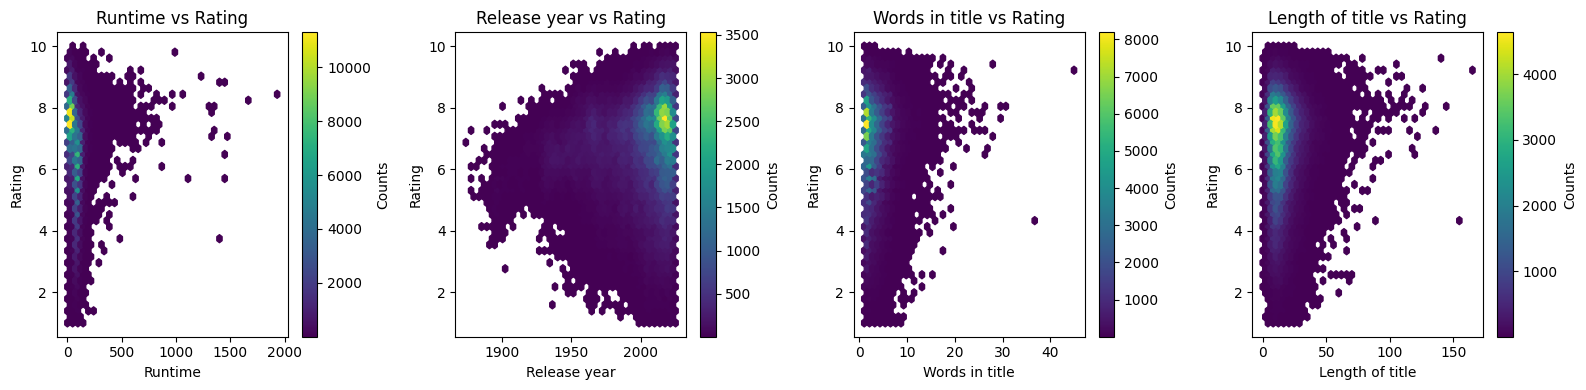

In [3]:
dataw.scatter_plots_features_vs_rating()

**Part 2**  


In [7]:
dataw.predict_linear_regression(x_new=2040)



np.float64(6.973640091113956)

**Part 3**

In [6]:
data_train, data_validation, data_test = dataw.train_val_test_split(seed=1)


In [6]:
print("Length of training set:", len(data_train))
print("Length of validation set:", len(data_validation))
print("Length of test set:", len(data_test))


Length of training set: 174568
Length of validation set: 37407
Length of test set: 37408


**Part 4**

In [7]:
model_b0, model_b1, model_mse = dataw.test_MSE()
print("Intercept (b0):", model_b0, "Slope (b1):", model_b1, "MSE:", model_mse)

Intercept (b0): -3.9450135854151833 Slope (b1): 0.005350648013942739 MSE: 1.8227317246494432


**Part 5**

Make a function to make NN. It would be essentially a wrapper of other libraries, I suggest to use Keras:  https://www.geeksforgeeks.org/machine-learning/how-to-create-models-in-keras/  . You should have acquired enough notions to handle this tool.

In [21]:
dataw.create_train_val_test() 
architectures = [
    [64, 32],
    [128, 64],
]
dataw.test_nn(architectures)

Best architecture: [64, 32] Validation MSE: 1.2297163009643555


I am getting a worse MSE from the neural network model, than from the basic linear regression. This might be because the data is mainly linear, and the NN do not capture a pattern.

**Part 7**  
Linear regression on the data

In [8]:
beta_all = dataw.linear_regression_multivariate(sklearn=False)

print(f"Corefficients: {beta_all}")

Corefficients: [-0.01029523  0.0036918   0.07188221 -0.00919613]


**Part 8 and 9**  
Linear regression on train data, then test and calculate MSE. Both with interception at 0 and not.

In [9]:
dataw.test_linreg_multivariate(sklearn=False)

Intercept: 0, Coefficients: [-0.01024131  0.00368991  0.07015701 -0.00883221]
This gives an MSE of: 1.6256500258709978


In [10]:
dataw.test_linreg_multivariate(sklearn=True)

Intercept: -2.631525579120459, Coefficients: [-0.01021205  0.00500058  0.07063948 -0.00867897]
This gives an MSE of: 1.6244342742982034
